In [19]:
import os
import glob
import sys

# Add path to PYTHONPATH
sys.path.append("/home/ysilvy/Density_bining/Yona_analysis/programs")

from netCDF4 import Dataset as open_ncfile
import matplotlib.pyplot as plt
from maps_matplot_lib import defVarmme, remapToZ, zon_2Dz
from modelsDef import defModels
import numpy as np
import colormaps as cmaps
import datetime


# ----- Workspace ------
indir_toe_rcphn = '/home/ysilvy/Density_bining/Yona_analysis/data/toe_zonal/toe_rcp85_histNat/'
indir_toe_rcppiC = '/home/ysilvy/Density_bining/Yona_analysis/data/toe_zonal/toe_rcp85_PiControl/'
indir_mme_rcp85 = '/data/ericglod/Density_binning/Prod_density_april15/mme_rcp85/'
indir_mme_hn = '/data/ericglod/Density_binning/Prod_density_april15/mme_histNat/'
indir_toe_CO2piC = '/home/ysilvy/Density_bining/Yona_analysis/data/toe_zonal/toe_1pctCO2_piC/'
indir_mme_CO2 = '/data/ericglod/Density_binning/Prod_density_april15/mme_1pctCO2/'
indir_mme_piC = '/data/ericglod/Density_binning/Prod_density_april15/mme_piControl/'

# ----- Work ------

# === INPUTS ===
work = 'RCP85'
# work = 'CO2'

figure = 'median'
# figure = 'range'

# output format
#outfmt = 'view'
outfmt = 'save'

use_piC = False # Signal = (hist-histNat) + RCP8.5-average(histNat), noise = std(histNat)
# use_piC = True # Signal = hist + RCP8.5 - average(PiControl), noise = std(PiControl)

# runs_rcp = 'same' # Same runs (30 runs) for hist+RCP8.5 vs. histNat as for hist+RCP8.5 vs. PiControl
runs_rcp = 'all' # All runs (35)

varname = defVarmme('salinity'); v = 'S'

multstd = 2 # detect ToE at multstd std dev of histnat/PiControl

nb_outliers = 5 # Nb of outlier runs allowed to compute the ToE distribution for hist + RCP8.5
nb_outliers_CO2 = 1 # Nb of outlier runs allowed to compute the ToE distribution for 1%CO2 vs. PiControl

In [20]:
# =====

if work == 'RCP85':
    iniyear = 1860
    finalyear = 2100
    models = defModels()
    min = 1980 # Start year for colorbar
    crit_min_runs = 5 # min number of runs with unmasked values = nruns-crit_min_runs
else:
    iniyear = 0
    finalyear = 140
    models = defModelsCO2piC()
    min = 20 # Start year for colorbar
    crit_min_runs = 1 # min number of runs with unmasked values = nruns-crit_min_runs
deltat = 10.

# density domain
rhomin = 21
rhomid = 26
rhomax = 28
domrho = [rhomin, rhomid, rhomax]

# ----- Variables ------
var = varname['var_zonal_w/bowl']
legVar = varname['legVar']
unit = varname['unit']

# Read latitude and density from original file
fileh_2d = '/data/ericglod/Density_binning/Prod_density_april15/mme_hist/' \
       'cmip5.multimodel_Nat.historical.ensm.an.ocn.Omon.density_zon2D.nc'
fh2d = open_ncfile(fileh_2d, 'r')
lat = fh2d.variables['latitude'][:]; latN = len(lat)
density = fh2d.variables['lev'][:]; levN = len(density)
basinN = 4

# ------------------------------------
# ----- Read ToE for each model ------
# ------------------------------------

if work == 'RCP85':
    # == Historical + RCP8.5 vs. historicalNat or vs. PiControl ==

    nruns = 0 # Initialize total number of runs
    nrunmax = 100
    nMembers = np.ma.empty(len(models)) # Initialize array for keeping number of members per model

    # -- Initialize varToE containing ToE of all runs
    varToEA = np.ma.masked_all((nrunmax, levN, latN))
    varToEP = np.ma.masked_all((nrunmax, levN, latN))
    varToEI = np.ma.masked_all((nrunmax, levN, latN))

    # -- Initialize varsignal (essential for knowing the sign of the emergence)
    varsignal_a = np.ma.masked_all((nrunmax, levN, latN))
    varsignal_p = np.ma.masked_all((nrunmax, levN, latN))
    varsignal_i = np.ma.masked_all((nrunmax, levN, latN))

    # Loop over models
    if use_piC == False:
        listfiles = glob.glob(indir_toe_rcphn + '/*.toe_zonal*.nc')
    else:
        listfiles = glob.glob(indir_toe_rcppiC + '/*.toe_zonal*.nc')
    nmodels = len(listfiles)
    print(len(listfiles))

    for i in range(nmodels):

        file_toe = listfiles[i]
        ftoe = open_ncfile(file_toe, 'r')
        name = os.path.basename(file_toe).split('.')[1]

        # If use same runs in vs. histNat as in vs. PiControl, take out deficient models
        if (runs_rcp == 'all') or (runs_rcp =='same' and name != 'GISS-E2-R' and name != 'FGOALS-g2' and name != 'MIROC-ESM'):

            # Read ToE (members, basin, density, latitude)
            if multstd == 1:
                toeread = ftoe.variables[var + 'ToE1'][:]
            else:
                toeread = ftoe.variables[var + 'ToE2'][:]
            nMembers[i] = toeread.shape[0]
            print('- Reading ToE of %s with %d members'%(name,nMembers[i]))
            nruns1 = int(nruns + nMembers[i])

            # Save ToE
            varToEA[nruns:nruns1,:,:] = toeread[:,1,:,:]
            varToEP[nruns:nruns1,:,:] = toeread[:,2,:,:]
            varToEI[nruns:nruns1,:,:] = toeread[:,3,:,:]

            # Read signal
            signalread = ftoe.variables[var + '_change'][:]

            # Save signal
            varsignal_a[nruns:nruns1,:,:] = signalread[:,1,:,:]
            varsignal_p[nruns:nruns1,:,:] = signalread[:,2,:,:]
            varsignal_i[nruns:nruns1,:,:] = signalread[:,3,:,:]

            nruns = nruns1

    print('Total number of runs:', nruns)
    varToEA = varToEA[0:nruns,:,:]
    varToEP = varToEP[0:nruns,:,:]
    varToEI = varToEI[0:nruns,:,:]
    varsignal_a = varsignal_a[0:nruns,:,:]
    varsignal_p = varsignal_p[0:nruns,:,:]
    varsignal_i = varsignal_i[0:nruns,:,:]

    nruns = int(nruns)

    if runs_rcp == 'same':
        nmodels=nmodels-3

else:
    # == 1%CO2 vs. PiControl ==

    listfiles = glob.glob(indir_toe_CO2piC + '/*.nc')
    nmodels = len(listfiles)

    # -- Initialize varToE containing ToE of all runs
    varToEA = np.ma.masked_all((nmodels, levN, latN))
    varToEP = np.ma.masked_all((nmodels, levN, latN))
    varToEI = np.ma.masked_all((nmodels, levN, latN))

    # -- Initialize varsignal (essential for knowing the sign of the emergence)
    varsignal_a = np.ma.masked_all((nmodels, levN, latN))
    varsignal_p = np.ma.masked_all((nmodels, levN, latN))
    varsignal_i = np.ma.masked_all((nmodels, levN, latN))

    # Loop over models
    for i in range(nmodels):

        file_toe = listfiles[i]
        ftoe = open_ncfile(file_toe, 'r')
        name = os.path.basename(file_toe).split('.')[1]
        # Read ToE (basin, density, latitude)
        if multstd == 1:
            toeread = ftoe.variables[var + 'ToE1'][:]
        else:
            toeread = ftoe.variables[var + 'ToE2'][:]
        print('- Reading ToE of %s'%(name,))

        # Save ToE
        varToEA[i,:,:] = toeread[1,:,:]
        varToEP[i,:,:] = toeread[2,:,:]
        varToEI[i,:,:] = toeread[3,:,:]

        # Read signal
        signalread = ftoe.variables[var + '_change'][:]

        # Save signal
        varsignal_a[i,:,:] = signalread[1,:,:]
        varsignal_p[i,:,:] = signalread[2,:,:]
        varsignal_i[i,:,:] = signalread[3,:,:]

    print('Total number of models:', nmodels)

    nruns = nmodels


11
- Reading ToE of IPSL-CM5A-LR with 3 members
- Reading ToE of CanESM2 with 5 members
- Reading ToE of FGOALS-g2 with 1 members
- Reading ToE of HadGEM2-ES with 2 members
- Reading ToE of MIROC-ESM with 1 members
- Reading ToE of CESM1-CAM5 with 3 members
- Reading ToE of CSIRO-Mk3-6-0 with 9 members
- Reading ToE of MIROC-ESM-CHEM with 1 members
- Reading ToE of GISS-E2-R with 3 members
- Reading ToE of IPSL-CM5A-MR with 1 members
- Reading ToE of CCSM4 with 6 members
Total number of runs: 35


In [21]:
# ----------------------------------------------------------------
# ----- Compute distribution according to Lyu et. al method ------
# ----------------------------------------------------------------

groups_a = np.ma.masked_all((nruns, levN, latN))
groups_p = np.ma.masked_all((nruns, levN, latN))
groups_i = np.ma.masked_all((nruns, levN, latN))
# Groups values : 0 for no emergence, 1 emergence with positive change, -1 emergence with negative change

# -- Check if emergence

groups_a = np.ma.where(varsignal_a>0,1,-1) # 1 if positive change, -1 if negative change
groups_a[np.ma.where(varToEA > finalyear-20)] = 0 # Overwrite with 0 if no emergence
groups_p = np.ma.where(varsignal_p>0,1,-1)
groups_p[np.ma.where(varToEP > finalyear-20)] = 0
groups_i = np.ma.where(varsignal_i>0,1,-1)
groups_i[np.ma.where(varToEI > finalyear-20)] = 0

nruns_a = np.ma.count(varsignal_a,axis=0) # Nb of runs with unmasked values
nruns_p = np.ma.count(varsignal_p,axis=0)
nruns_i = np.ma.count(varsignal_i,axis=0)

# -- Initialize median and percentiles
medianToEA = np.ma.masked_all((levN, latN))
medianToEP = np.ma.masked_all((levN, latN))
medianToEI = np.ma.masked_all((levN, latN))
percentile25ToEA = np.ma.masked_all((levN, latN))
percentile25ToEP = np.ma.masked_all((levN, latN))
percentile25ToEI = np.ma.masked_all((levN, latN))
percentile75ToEA = np.ma.masked_all((levN, latN))
percentile75ToEP = np.ma.masked_all((levN, latN))
percentile75ToEI = np.ma.masked_all((levN, latN))

# -- Initialize where there is no agreement between models on the sign of the signal
noagree_a = np.ma.masked_all((levN, latN))
noagree_p = np.ma.masked_all((levN, latN))
noagree_i = np.ma.masked_all((levN, latN))

# -- Compute distribution if conditions are met 

varToEA_clean = np.ma.masked_all((nruns,levN,latN))
varToEP_clean = np.ma.masked_all((nruns,levN,latN))
varToEI_clean = np.ma.masked_all((nruns,levN,latN))

# TODO maybe use reshape instead of double loop ? Check feasability --> idem TOE computation
for ilat in range(len(lat)):
    for isig in range(len(density)):

        # -- Atlantic
        if nruns_a[isig,ilat] >= nruns - crit_min_runs :
            # Positive emergence
            if ((groups_a[:,isig,ilat]==1).sum() > nruns_a[isig,ilat]/2) and ((groups_a[:,isig,ilat]==-1).sum() < nb_outliers):
                varToEA_clean[np.where(groups_a[:,isig,ilat]!=-1),isig,ilat] = varToEA[np.where(groups_a[:,isig,ilat]!=-1),isig,ilat]
                # print(varToEA_clean[:,isig,ilat])
            # Negative emergence
            elif ((groups_a[:,isig,ilat]==-1).sum() > nruns_a[isig,ilat]/2) and ((groups_a[:,isig,ilat]==1).sum() < nb_outliers):
                 varToEA_clean[np.where(groups_a[:,isig,ilat]!=1),isig,ilat] = varToEA[np.where(groups_a[:,isig,ilat]!=1),isig,ilat]
                 # print(varToEA_clean[:,isig,ilat])
            # No emergence
            elif ((groups_a[:,isig,ilat]==0).sum() > nruns_a[isig,ilat]/2) and ((groups_a[:,isig,ilat]==1).sum()<=nb_outliers or
                    (groups_a[:,isig,ilat]==-1).sum()<=nb_outliers):
                if (groups_a[:,isig,ilat]==1).sum() > (groups_a[:,isig,ilat]==-1).sum() :
                    varToEA_clean[np.where(groups_a[:,isig,ilat]!=-1),isig,ilat] = varToEA[np.where(groups_a[:,isig,ilat]!=-1),isig,ilat]
                else:
                    varToEA_clean[np.where(groups_a[:,isig,ilat]!=1),isig,ilat] = varToEA[np.where(groups_a[:,isig,ilat]!=1),isig,ilat]
            # No agreement between models
            else:
                noagree_a[isig,ilat] = 1
                varToEA_clean[:,isig,ilat] = varToEA[:,isig,ilat]

        # -- Pacific
        if nruns_p[isig,ilat] >= nruns - crit_min_runs :
            # Positive emergence
            if ((groups_p[:,isig,ilat]==1).sum() > nruns_p[isig,ilat]/2) and ((groups_p[:,isig,ilat]==-1).sum() < nb_outliers):
                varToEP_clean[np.where(groups_p[:,isig,ilat]!=-1),isig,ilat] = varToEP[np.where(groups_p[:,isig,ilat]!=-1),isig,ilat]
            # Negative emergence
            elif ((groups_p[:,isig,ilat]==-1).sum() > nruns_p[isig,ilat]/2) and ((groups_p[:,isig,ilat]==1).sum() < nb_outliers):
                 varToEP_clean[np.where(groups_p[:,isig,ilat]!=1),isig,ilat] = varToEP[np.where(groups_p[:,isig,ilat]!=1),isig,ilat]
            # No emergence
            elif ((groups_p[:,isig,ilat]==0).sum() > nruns_p[isig,ilat]/2) and ((groups_p[:,isig,ilat]==1).sum()<=nb_outliers or
                    (groups_p[:,isig,ilat]==-1).sum()<=nb_outliers):
                if (groups_p[:,isig,ilat]==1).sum() > (groups_p[:,isig,ilat]==-1).sum() :
                    varToEP_clean[np.where(groups_p[:,isig,ilat]!=-1),isig,ilat] = varToEP[np.where(groups_p[:,isig,ilat]!=-1),isig,ilat]
                else:
                    varToEP_clean[np.where(groups_p[:,isig,ilat]!=1),isig,ilat] = varToEP[np.where(groups_p[:,isig,ilat]!=1),isig,ilat]
            # No agreement between models
            else:
                noagree_p[isig,ilat] = 1
                varToEP_clean[:,isig,ilat] = varToEP[:,isig,ilat]

        # -- Indian
        if nruns_i[isig,ilat] >= nruns - crit_min_runs :
            # Positive emergence
            if ((groups_i[:,isig,ilat]==1).sum() > nruns_i[isig,ilat]/2) and ((groups_i[:,isig,ilat]==-1).sum() < nb_outliers):
                varToEI_clean[np.where(groups_i[:,isig,ilat]!=-1),isig,ilat] = varToEI[np.where(groups_i[:,isig,ilat]!=-1),isig,ilat]
            # Negative emergence
            elif ((groups_i[:,isig,ilat]==-1).sum() > nruns_i[isig,ilat]/2) and ((groups_i[:,isig,ilat]==1).sum() < nb_outliers):
                 varToEI_clean[np.where(groups_i[:,isig,ilat]!=1),isig,ilat] = varToEI[np.where(groups_i[:,isig,ilat]!=1),isig,ilat]
            # No emergence
            elif ((groups_i[:,isig,ilat]==0).sum() > nruns_i[isig,ilat]/2) and ((groups_i[:,isig,ilat]==1).sum()<=nb_outliers or
                    (groups_i[:,isig,ilat]==-1).sum()<=nb_outliers):
                if (groups_i[:,isig,ilat]==1).sum() > (groups_i[:,isig,ilat]==-1).sum() :
                    varToEI_clean[np.where(groups_i[:,isig,ilat]!=-1),isig,ilat] = varToEI[np.where(groups_i[:,isig,ilat]!=-1),isig,ilat]
                else:
                    varToEI_clean[np.where(groups_i[:,isig,ilat]!=1),isig,ilat] = varToEI[np.where(groups_i[:,isig,ilat]!=1),isig,ilat]
            # No agreement between models
            else:
                noagree_i[isig,ilat] = 1
                varToEI_clean[:,isig,ilat] = varToEI[:,isig,ilat]

print('Loops done')
medianToEA = np.ma.around(np.ma.median(varToEA_clean, axis=0)) + iniyear
percentile25ToEA = np.ma.around(np.percentile(varToEA_clean, 25, axis=0)) + iniyear
percentile75ToEA = np.ma.around(np.percentile(varToEA_clean, 75, axis=0)) + iniyear
medianToEP = np.ma.around(np.ma.median(varToEP_clean, axis=0)) + iniyear
percentile25ToEP = np.ma.around(np.percentile(varToEP_clean, 25, axis=0)) + iniyear
percentile75ToEP = np.ma.around(np.percentile(varToEP_clean, 75, axis=0)) + iniyear
medianToEI = np.ma.around(np.ma.median(varToEI_clean, axis=0)) + iniyear
percentile25ToEI = np.ma.around(np.percentile(varToEI_clean, 25, axis=0)) + iniyear
percentile75ToEI = np.ma.around(np.percentile(varToEI_clean, 75, axis=0)) + iniyear

# 25-75% range
rangeToEA = percentile75ToEA - percentile25ToEA
rangeToEP = percentile75ToEP - percentile25ToEP
rangeToEI = percentile75ToEI - percentile25ToEI

rangeToEA[percentile75ToEA>finalyear-20] = np.ma.masked
norangeA = np.where(percentile75ToEA>finalyear-20,1,0)
rangeToEP[percentile75ToEP>finalyear-20] = np.ma.masked
norangeP = np.where(percentile75ToEP>finalyear-20,1,0)
rangeToEI[percentile75ToEI>finalyear-20] = np.ma.masked
norangeI = np.where(percentile75ToEI>finalyear-20,1,0)

# Mask
rangeToEA[rangeToEA==0] = np.ma.masked
rangeToEP[rangeToEP==0] = np.ma.masked
rangeToEI[rangeToEI==0] = np.ma.masked

Loops done


In [22]:
# -----------------------------------------------       
# -------- Mask above bowl (in sigma) -----------
# -----------------------------------------------
# Use multimodel bowl ?

In [23]:
# ------------------------------        
# -------- Remapping -----------
# ------------------------------

# -- Regroup basins
medianToEr = np.ma.masked_all((basinN,levN,latN))
medianToEr[1,:,:] = medianToEA
medianToEr[2,:,:] = medianToEP
medianToEr[3,:,:] = medianToEI

rangeToEr = np.ma.masked_all((basinN,levN,latN))
rangeToEr[1,:,:] = rangeToEA
rangeToEr[2,:,:] = rangeToEP
rangeToEr[3,:,:] = rangeToEI

noagreer = np.ma.masked_all((basinN,levN,latN))
noagreer[1,:,:] = noagree_a
noagreer[2,:,:] = noagree_p
noagreer[3,:,:] = noagree_i

noranger = np.ma.masked_all((basinN,levN,latN))
noranger[1,:,:] = norangeA
noranger[2,:,:] = norangeP
noranger[3,:,:] = norangeI

# ----- Read volume and depth of isopycnals ------

# Read files
file1d_rcp85 = 'cmip5.multimodel_Nat.rcp85.ensm.an.ocn.Omon.density_zon1D.nc'
f1drcp85 = open_ncfile(indir_mme_rcp85+file1d_rcp85,'r')
file2d_rcp85 = 'cmip5.multimodel_Nat.rcp85.ensm.an.ocn.Omon.density_zon2D.nc'
f2drcp85 = open_ncfile(indir_mme_rcp85+file2d_rcp85,'r')
file_hn = 'cmip5.multimodel_Nat.historicalNat.ensm.an.ocn.Omon.density_zon1D.nc'
fhn = open_ncfile(indir_mme_hn+file_hn,'r')

# Read variables
depthr = f2drcp85.variables['isondepth'][-5:,:,:,:]
volumr = f2drcp85.variables['isonvol'][-5:,:,:,:]
bowl2z = f1drcp85.variables['ptopdepth'][-5:,:,:]
bowl1z = fhn.variables['ptopdepth'][-5:,:,:]

# Average
depthr = np.ma.average(depthr, axis=0)
volumr = np.ma.average(volumr, axis=0)
bowl2z = np.ma.average(bowl2z, axis=0)
bowl1z = np.ma.average(bowl1z, axis=0)

labBowl = None #['histNat','RCP8.5']

# ----- Bathymetry ------

# Read masks
fmask = open_ncfile('/home/ysilvy/Density_bining/Yona_analysis/data/170224_WOD13_masks.nc','r')
basinmask = fmask.variables['basinmask3'][:] # (latitude, longitude)
depthmask = fmask.variables['depthmask'][:] # (latitude, longitude)
# Create basin masks
mask_a = basinmask != 1
mask_p = basinmask != 2
mask_i = basinmask != 3
# Take max value along lon for each latitude of each basin --> gives us the bathymetry
depthmask_a = np.ma.array(depthmask, mask=mask_a)
bathy_a = np.ma.max(depthmask_a, axis=1)
depthmask_p = np.ma.array(depthmask, mask=mask_p)
bathy_p = np.ma.max(depthmask_p, axis=1)
depthmask_i = np.ma.array(depthmask, mask=mask_i)
bathy_i = np.ma.max(depthmask_i, axis=1)

bathy = np.ma.masked_all((basinN,len(lat)))
bathy[1,:] = bathy_a
bathy[2,:] = bathy_p
bathy[3,:] = bathy_i


# ----- Remapping -----

# WOA13 grid
targetz = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
   85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375,
   400, 425, 450, 475, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950,
   1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550,
   1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2100, 2200, 2300,
   2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500,
   3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700,
   4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500]

depthr2 = depthr
depthr3 = depthr
depthr4 = depthr

medianToEz = np.ma.around(remapToZ(medianToEr.data, depthr, volumr, targetz, bowl2z, bathy))
print('Median remapping done')
rangeToEz = np.ma.around(remapToZ(rangeToEr.data, depthr2, volumr, targetz, bowl2z, bathy))
print('Range remapping done')
noagreez = remapToZ(noagreer.data, depthr3, volumr, targetz, bowl2z, bathy)
print('noagree remapping done')
norangez = remapToZ(noranger.data, depthr4, volumr, targetz, bowl2z, bathy)
print('norange remapping done')


Median remapping done
Range remapping done
noagree remapping done
norange remapping done


In [6]:
# # Mask above bowl2z
# for ilat in range(len(lat)):
#     if np.ma.is_masked(bowl2z[1,ilat]) == False :
#         inda = np.ma.nonzero(bowl2z[1,ilat]>=targetz)
#         medianToEz[1,inda,ilat] = np.ma.masked
#         rangeToEz[1,inda,ilat] = np.ma.masked
#         noagreez[1,inda,ilat] = np.ma.masked
#         norangez[1,inda,ilat] = np.ma.masked
#     if np.ma.is_masked(bowl2z[2,ilat]) == False :
#         indp = np.ma.nonzero(bowl2z[2,ilat]>=targetz)
#         medianToEz[2,indp,ilat] = np.ma.masked
#         rangeToEz[2,indp,ilat] = np.ma.masked
#         noagreez[2,indp,ilat] = np.ma.masked
#         norangez[2,indp,ilat] = np.ma.masked
#     if np.ma.is_masked(bowl2z[3,ilat]) == False :
#         indi = np.ma.nonzero(bowl2z[3,ilat]>=targetz)
#         medianToEz[3,indi,ilat] = np.ma.masked
#         rangeToEz[3,indi,ilat] = np.ma.masked
#         noagreez[3,indi,ilat] = np.ma.masked
#         norangez[3,indi,ilat] = np.ma.masked

In [24]:
# Mask
#rangeToEz[medianToEz > finalyear-20] = np.ma.masked # Mask points where median hasn't emerged
#medianToEz[noagreez==1] = np.ma.masked
medianToEz[medianToEz<iniyear] = np.ma.masked
rangeToEz[rangeToEz==0] = np.ma.masked

# -- Make variable bundles for each basin
varAtlmedian = {'name': 'Atlantic', 'var_change': medianToEz[1,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': labBowl, 'density':None}
varPacmedian = {'name': 'Pacific', 'var_change': medianToEz[2,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': labBowl, 'density':None}
varIndmedian = {'name': 'Indian', 'var_change': medianToEz[3,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': labBowl, 'density':None}

varAtlrange = {'name': 'Atlantic', 'var_change': rangeToEz[1,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': labBowl, 'density':None}
varPacrange = {'name': 'Pacific', 'var_change': rangeToEz[2,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': labBowl, 'density':None}
varIndrange = {'name': 'Indian', 'var_change': rangeToEz[3,:,:], 'bowl1': None, 'bowl2': None, 'labBowl': labBowl, 'density':None}


/home/ysilvy/.conda/envs/mypython3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


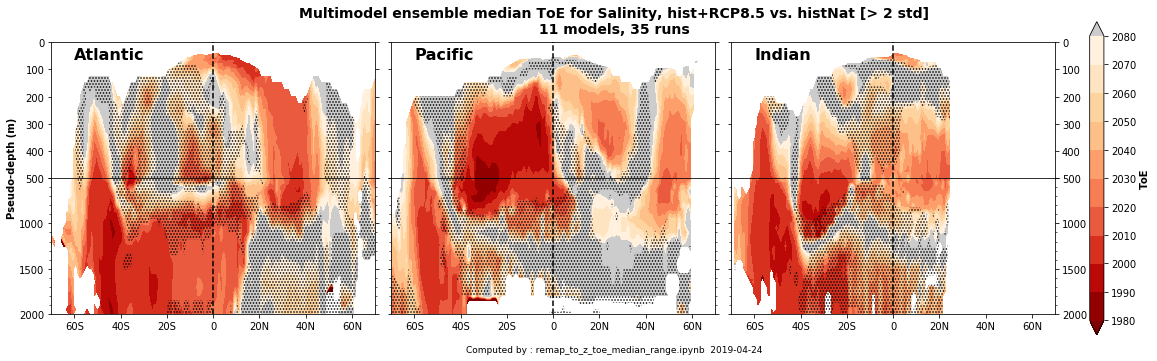

In [25]:
# ----- Plot -----
from maps_matplot_lib import zon_2Dz
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

domzed = [0,500,2000]
# Create meshgrid
lat2d, lev2d = np.meshgrid(lat, targetz)

# Date
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

# -- Median

# -- Create figure and axes instances
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 5))

# -- Color map
cmap = 'OrRd_r' #'jet_r' #'YlOrRd_r' #'viridis'
# -- Unit
unit = 'ToE'
# -- Levels
minmax = [min, 2080.01, deltat]
levels = np.arange(minmax[0], minmax[1], minmax[2])
ext_cmap = 'both'
# -- Put everything into a dictionary
contourDict = {'cmap':cmap, 'levels':levels, 'ext_cmap':ext_cmap, 'isopyc':False}

# -- Contourf
# Atlantic
cnplot = zon_2Dz(plt, axes[0,0], axes[1,0], 'left', lat, targetz, varAtlmedian,
                  contourDict, domzed, None, None)
cnplot[0].cmap.set_over('0.8')
cnplot[1].cmap.set_over('0.8')
axes[0,0].contourf(lat2d, lev2d, noagreez[1,:,:], levels=[0.25,0.5,1.5], colors='None',
                             hatches=['','....'], edgecolor='0.3', linewidth=0.0) # No agreement
axes[1,0].contourf(lat2d, lev2d, noagreez[1,:,:], levels=[0.25,0.5,1.5], colors='None',
                             hatches=['','....'], edgecolor='0.3', linewidth=0.0)

# -- Add colorbar
cb = fig.colorbar(cnplot[1], ax=axes.ravel().tolist(), ticks=levels, fraction=0.015, shrink=2.0, pad=0.05)
cb.set_label('%s' % (unit,), fontweight='bold')

# Pacific
cnplot = zon_2Dz(plt, axes[0,1], axes[1,1], 'mid', lat, targetz, varPacmedian,
                  contourDict, domzed, None, None)
cnplot[0].cmap.set_over('0.8')
cnplot[1].cmap.set_over('0.8')
axes[0,1].contourf(lat2d, lev2d, noagreez[2,:,:], levels=[0.25,0.5,1.5], colors='None',
                             hatches=['','....'], edgecolor='0.3', linewidth=0.0) # No agreement
axes[1,1].contourf(lat2d, lev2d, noagreez[2,:,:], levels=[0.25,0.5,1.5], colors='None',
                             hatches=['','....'], edgecolor='0.3', linewidth=0.0)

# Indian
cnplot = zon_2Dz(plt, axes[0,2], axes[1,2], 'right', lat, targetz, varIndmedian,
                  contourDict, domzed, None, None)
cnplot[0].cmap.set_over('0.8')
cnplot[1].cmap.set_over('0.8')
axes[0,2].contourf(lat2d, lev2d, noagreez[3,:,:], levels=[0.25,0.5,1.5], colors='None',
                             hatches=['','....'], edgecolor='0.3', linewidth=0.0) # No agreement
axes[1,2].contourf(lat2d, lev2d, noagreez[3,:,:], levels=[0.25,0.5,1.5], colors='None',
                             hatches=['','....'], edgecolor='0.3', linewidth=0.0)

plt.subplots_adjust(hspace=.0001, wspace=0.05, left=0.04, right=0.86)


# -- Add title
plotTitle = 'Multimodel ensemble median ToE for ' + legVar + ', hist+RCP8.5 vs. histNat [> ' + str(multstd) + ' std]' \
    '\n %d models, %d runs '%(nmodels,nruns)

plt.suptitle(plotTitle, fontweight='bold', fontsize=14, verticalalignment='top')

plt.figtext(.5,.02,'Computed by : remap_to_z_toe_median_range.ipynb  '+date,fontsize=9,ha='center')
plt.figtext(.004,.65,'Pseudo-depth (m)',rotation='vertical',fontweight='bold')

figureDir = 'models/zonal_remaptoz/'
plotName = 'remapping_median_toe_rcp85vshistNat_'+ str(nb_outliers)+'_outliers_'+str(multstd)+'std'
#if fig == 'save':
#plt.savefig('/home/ysilvy/figures/'+figureDir+plotName+'.pdf', bbox_inches='tight')
